In [165]:
# Setup notebook
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from utils import plot_periodogram, seasonal_plot



comp_dir = Path('./input')

holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

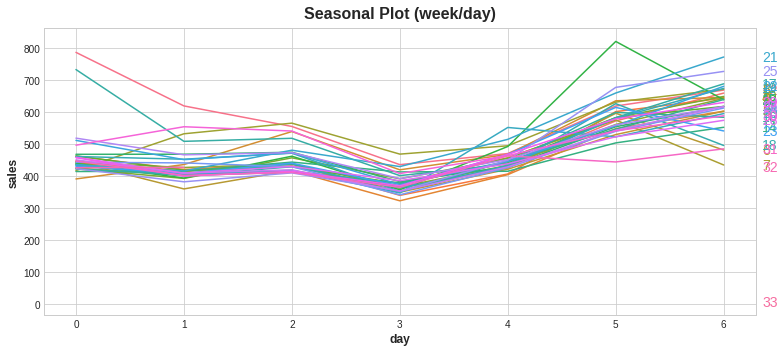

In [166]:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');

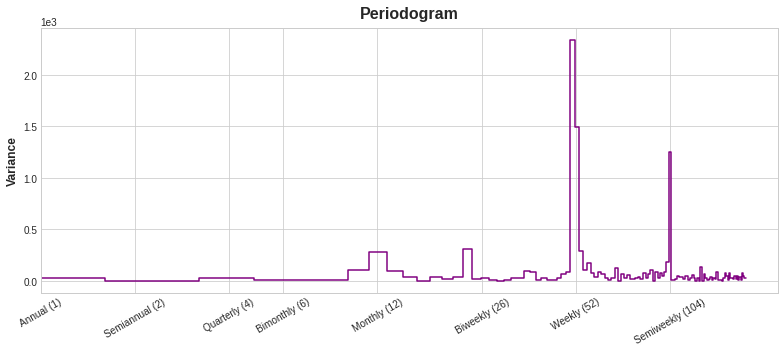

In [167]:
plot_periodogram(average_sales);

In [168]:
y = average_sales.copy()
# YOUR CODE HERE
fourier = CalendarFourier(freq="M", order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    # YOUR CODE HERE
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample() 


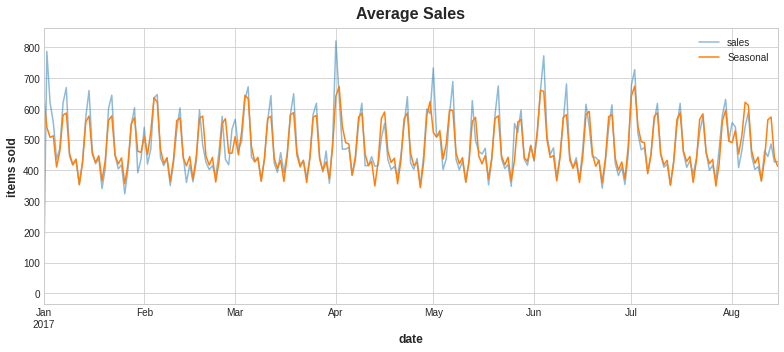

In [169]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

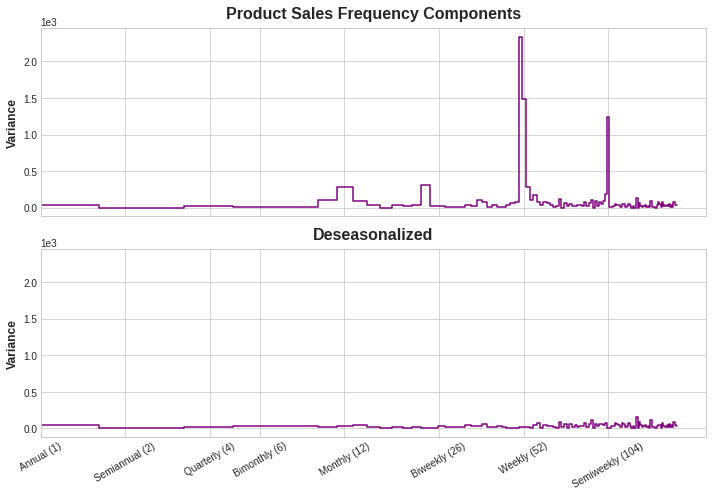

In [170]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

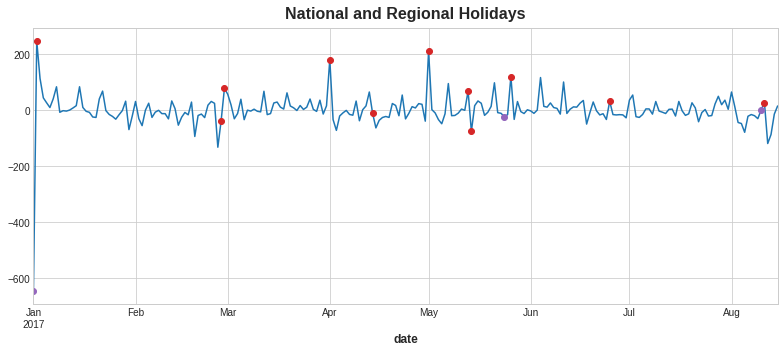

In [171]:
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description', 'transferred']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)
holidays[holidays['transferred']==False]
ax = y_deseason.plot()
transferred_holidays = holidays[holidays['transferred']==True]
not_transferred_holidays = holidays[holidays['transferred']==False]
plt.plot_date(transferred_holidays.index, y_deseason[transferred_holidays.index], color='C4')
plt.plot_date(not_transferred_holidays.index, y_deseason[not_transferred_holidays.index], color='C3')

ax.set_title('National and Regional Holidays');

In [172]:
X_holidays = pd.get_dummies(holidays)

In [173]:
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)
# X = X.join(X_holidays, on='date').fillna(0.0) no mejoro 
# X = X.join(X_holidays, on='date').fillna(0.0) no mejoro 


model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

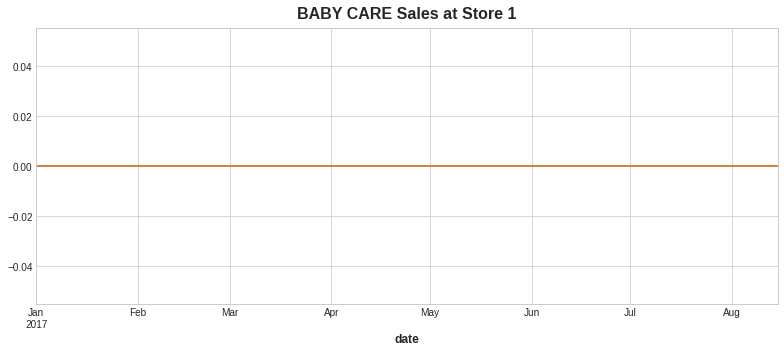

In [174]:
STORE_NBR = '1'  # 1 - 54
FAMILY = 'BABY CARE'
# Uncomment to see a list of product families
# display(store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot()
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

In [175]:
store_sales.index.get_level_values('family').unique()

CategoricalIndex(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
                  'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI',
                  'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II',
                  'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II',
                  'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR',
                  'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER',
                  'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES',
                  'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
                  'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
                 categories=['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', ...], ordered=False, dtype='category', name='family')

In [176]:
df_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)
# X_test = X_test.join(X_holidays, on='date').fillna(0.0)


y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)

# tests

In [177]:
store_ids = store_sales.index.get_level_values('store_nbr').unique().sort_values()
families = store_sales.index.get_level_values('family').unique().sort_values()

In [178]:
STORE_NBR = '2'  # 1 - 54
FAMILY = 'AUTOMOTIVE' # families

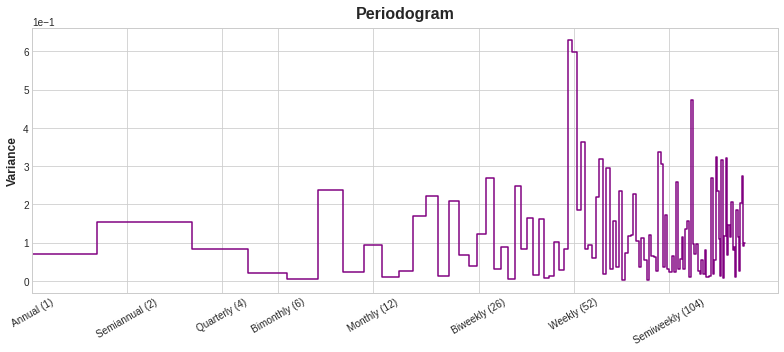

In [179]:
sales = store_sales.loc[STORE_NBR,:].loc[FAMILY,:].sort_index().loc['2017']
plot_periodogram(sales.squeeze().loc['2017']);

In [180]:
def get_best_freq(ts, detrend='linear', ax=None):
    ''' return 's' : second
        'min' : minute
        'H' : hour
        'D' : day
        'SM' : semiweekly
        'w' : week
        '2w' : biweekly
        'm' : month
    '''
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    na, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    options = {
        1: 'y', 
        2: '6m', 
        4: '3m', 
        6: '2m', 
        12: 'm', 
        26: '2w', 
        52: 'w', 
        104: 'sw'
    }  
    max_value_index = np.where(np.max(spectrum) == spectrum)
    early_max_value = min(options.keys(), key=lambda x:abs(x-max_value_index[0][0]))
    values = {spectrum[number]: frequency for number, frequency in options.items()}
    return options[early_max_value]

freq = get_best_freq(sales.squeeze())
freq


'2w'

## Train

In [181]:
# Create training data
y = sales

fourier = CalendarFourier(freq=freq, order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)
# X = X.join(X_holidays, on='date').fillna(0.0) no mejoro 


model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)# options.keys()

## Result

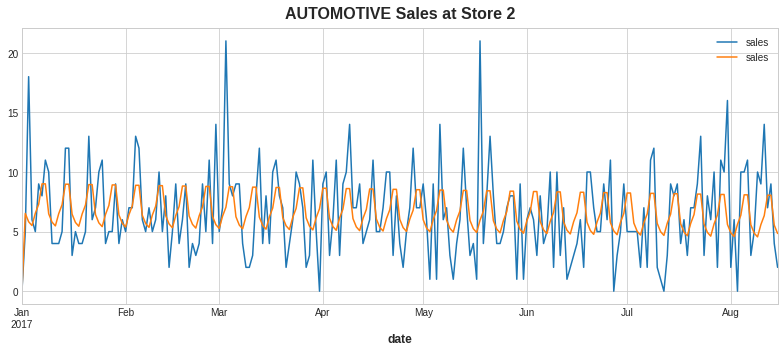

In [182]:
ax = y.plot()
ax = y_pred.plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

## CONTINUE

In [183]:
def get_best_freq(ts, detrend='linear', ax=None):
    ''' return 's' : second
        'min' : minute
        'H' : hour
        'D' : day
        'SM' : semiweekly
        'w' : week
        '2w' : biweekly
        'm' : month
    '''
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    na, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    options = {
        1: 'y', 
        2: '6m', 
        4: '3m', 
        6: '2m', 
        12: 'm', 
        26: '2w', 
        52: 'w', 
        # 104: 'SM'
    }  
    max_value_index = np.where(np.max(spectrum) == spectrum)
    early_max_value = min(options.keys(), key=lambda x:abs(x-max_value_index[0][0]))
    values = {spectrum[number]: frequency for number, frequency in options.items()}
    return options[early_max_value]

def get_model(store_nbr, family):
    sales = store_sales.loc[store_nbr,:].loc[family,:].sort_index().loc['2017']
    # ax = plot_periodogram(sales.squeeze().loc['2017']);
    #####################
    # meta parameters
    #####################
    freq = get_best_freq(sales.squeeze())
    # print(freq)
    #####################
    # train
    #####################
    y = sales
    fourier = CalendarFourier(freq=freq, order=4)
    dp = DeterministicProcess(
        index=y.index,
        constant=True,
        order=1,
        seasonal=True,
        additional_terms=[fourier],
        drop=True,
    )
    X = dp.in_sample()
    X['NewYear'] = (X.index.dayofyear == 1)
    # X = X.join(X_holidays, on='date').fillna(0.0) no mejoro 

    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)
    #####################
    # train
    #####################
    y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)# options.keys()
    return model, dp, y
    # ax = y.plot()
    # ax = y_pred.plot(ax=ax)
    # ax.set_title(f'{family} Sales at Store {store_nbr} frequency {freq}');


In [184]:
df_store_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_store_test['date'] = df_store_test.date.dt.to_period('D')
df_store_test = df_store_test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [219]:

store_models = {}
y_submit = pd.DataFrame(columns=['id', 'sales'])
for store_nbr in store_ids:
    for family in families:
        # family = FAMILY
        model, dp, y = get_model(store_nbr, family)
        # # Create features for test set
        X_test = dp.out_of_sample(steps=16)
        X_test.index.name = 'date'
        X_test['NewYear'] = (X_test.index.dayofyear == 1)
        # X_test = X_test.join(X_holidays, on='date').fillna(0.0) no funciono

        df_test = df_store_test.loc[store_nbr, :].loc[family,:].sort_index()
        result = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
        result = result.join(df_test.id)
        # print(result)
        y_submit = pd.concat([y_submit, result])

y_submit.sort_values('id', inplace=True)
print(y_submit.head())

                 id        sales
2017-08-16  3000888     4.823290
2017-08-16  3000889     0.000000
2017-08-16  3000890     3.495530
2017-08-16  3000891  2421.674748
2017-08-16  3000892     0.412388


In [222]:
y_submit.to_csv('submission.csv', index=False)

In [195]:
# X_test = df_test.loc[STORE_NBR, :].loc[FAMILY,:].sort_index()
# X_test

In [ ]:
# # Create features for test set
# X_test = dp.out_of_sample(steps=16)
# X_test.index.name = 'date'
# X_test['NewYear'] = (X_test.index.dayofyear == 1)
# # X_test = X_test.join(X_holidays, on='date').fillna(0.0)


# y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
# y_submit = y_submit.stack(['store_nbr', 'family'])
# y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
# y_submit.to_csv('submission.csv', index=False)

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)",NewYear
date,,,,,,,,,,,,,,,,,
2017-08-16,1.0,228.0,0.0,0.0,1.0,0.0,0.0,0.0,0.101168,-0.994869,-0.201299,0.979530,0.299363,-0.954139,-0.394356,0.918958,False
2017-08-17,1.0,229.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.101168,-0.994869,0.201299,0.979530,-0.299363,-0.954139,0.394356,0.918958,False
2017-08-18,1.0,230.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.299363,-0.954139,0.571268,0.820763,-0.790776,-0.612106,0.937752,0.347305,False
2017-08-19,1.0,231.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.485302,-0.874347,0.848644,0.528964,-0.998717,-0.050649,0.897805,-0.440394,False
2017-08-20,1.0,232.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.651372,-0.758758,0.988468,0.151428,-0.848644,0.528964,0.299363,-0.954139,False
2017-08-21,1.0,233.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.790776,-0.612106,0.968077,-0.250653,-0.394356,0.918958,-0.485302,-0.874347,False
2017-08-22,1.0,234.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.897805,-0.440394,0.790776,-0.612106,0.201299,0.979530,-0.968077,-0.250653,False
2017-08-23,1.0,235.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.968077,-0.250653,0.485302,-0.874347,0.724793,0.688967,-0.848644,0.528964,False
2017-08-24,1.0,236.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.998717,-0.050649,0.101168,-0.994869,0.988468,0.151428,-0.201299,0.979530,False
